# **(PCA) of multidimensional points **


In this Jupyter notebook, we will be performing Principal Component Analysis (PCA) using the points provided is exp_2d_blobs using the easy approach.

In [56]:
from time import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
from sklearn.datasets import make_blobs
import pylab as pl
from sklearn.cluster import Birch, MiniBatchKMeans
from sklearn.mixture import GaussianMixture
# from robotikos.metric import IdentityFeature
# from robotikos.metric import (NormalizedSumSquaredDiffMetric,
#                               NormalizedSumAbsDiffMetric)
from thetan.theta import theta_g1, assign
from thetan.theta import distance_matrix as tdm
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, silhouette_score, fowlkes_mallows_score

import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

### Accuracy with 2d data 

In [57]:
    evaluation_thr = 0.1
    verbose = True
    show_thr = False
    radius = 4
    n_local_samples = 30
    blob_dis = 33
    cluster_per_dim = 10
    scores = {}
    timings = {}
    blob_dis = 10
    cluster_x = 10
    cluster_y = 10
    
    xx = np.arange(-1*blob_dis*cluster_x//2, blob_dis*cluster_x//2, blob_dis)
    yy = np.arange(-1*blob_dis*cluster_y//2, blob_dis*cluster_y//2, blob_dis)

    xx, yy = np.meshgrid(xx, yy)
    n_centres = np.hstack((np.ravel(xx)[:, np.newaxis],
                        np.ravel(yy)[:, np.newaxis]))



    gt_centroids = []
    X = np.zeros((n_local_samples * n_centres.shape[0], 2))
    y = np.zeros((n_local_samples * n_centres.shape[0]), dtype=np.int16)
    for i in range(n_centres.shape[0]):
        cpos = n_centres[i]

        local_X = cpos + np.random.normal(0, 1, (n_local_samples, 2))
        X[i * n_local_samples: (i + 1) * n_local_samples] = local_X
        y[i * n_local_samples: (i + 1) * n_local_samples] = i
        gt_centroids.append(local_X.mean(axis=0))

    gt_centroids = np.array(gt_centroids)

    points = X
    labels = y
    sz = len(n_centres)

    centroids = gt_centroids
    
    print('Before shuffling')
    print(points[:10])

    points_idx = np.arange(np.shape(points)[0])
    np.random.shuffle(points_idx)
    new_points = np.zeros(np.shape(points))
    new_labels = np.zeros(np.shape(labels))
    for i, idx in zip(range(np.shape(points)[0]), points_idx):
        new_points[i] = points[idx]
        new_labels[i] = labels[idx]

    points = new_points
    labels = new_labels

    print('After shuffling')
    print(points[:10])

    print('Number of points ', points.shape)

    print('Number of gold centroids ', np.prod(sz))

    # kmeans ++ 
    t1 = time()
    kmeans = KMeans(n_clusters=np.prod(sz), init='k-means++', n_init=1,
                    max_iter=300, tol=0.0001, random_state=0).fit(points)
    t2 = time()

    kmeans_time = t2 - t1
    print('kmeans++ ', kmeans_time)

    kcentroids = kmeans.cluster_centers_
    klabels = kmeans.labels_
    # if verbose:
    #     plot_centroids_clusters(points, kcentroids, klabels,
    #                             'kmeans++', exp_type,
    #                             initial_centroids=centroids)

    # scores['kmeans++'] = {}
    # for mode in modes:
    #     if mode == 'SIL':
    #         scores['kmeans++'][mode] = evaluate_centroids(thr=evaluation_thr, mode=mode, X=points, label=klabels)
    #     elif mode == 'NMI' or mode == 'FMS' or mode == 'RAI':
    #         scores['kmeans++'][mode] = evaluate_centroids(thr=evaluation_thr, mode=mode, label=klabels, true_label=labels)
    #     elif mode == 'SSD':
    #         scores['kmeans++'][mode] = evaluate_centroids(kcentroids, centroids, evaluation_thr, mode=mode)
    # timings['kmeans++'] = kmeans_time

    tmp = 0
    
    #thetan
    theta = 6.0

    t1 = time()
    tcentroids, tlabels = theta_g1(points, theta=theta,)

    t2 = time()

    tm_time = t2 - t1
    print('tm ', tm_time)
    print('Speedup', kmeans_time/tm_time)




Before shuffling
[[-50.67786167 -51.16328598]
 [-48.66965069 -49.49047462]
 [-50.96982391 -48.57671832]
 [-50.64195649 -47.9078772 ]
 [-48.76872006 -52.02235988]
 [-49.32227681 -50.01428752]
 [-48.55727332 -49.81429807]
 [-48.90317451 -50.0200366 ]
 [-49.8669566  -49.14383661]
 [-49.93433053 -52.21525652]]
After shuffling
[[  8.85228819 -29.39427544]
 [ 40.5134711  -38.72473972]
 [-48.91489122 -52.19007594]
 [ 21.90697827  29.13880625]
 [ 32.54658778  12.98885871]
 [ -0.09015575 -51.46959829]
 [-20.57407745 -20.81262503]
 [-10.21723565 -49.29370758]
 [-48.91872674  18.69217393]
 [-39.96510093 -30.20907945]]
Number of points  (3000, 2)
Number of gold centroids  100
kmeans++  0.05647110939025879
tm  0.0024662017822265625
Speedup 22.898008507347253


In [68]:
print("tshape")
print(tcentroids.shape)
print("kshape")
print(kcentroids.shape)
print(klabels.shape)

tshape
(100, 2)
kshape
(100, 2)
(3000,)


### Normalized Mutual Information (NMI) 
is a normalization of the Mutual Information (MI) score to scale the results between 0 (no mutual information) and 1 (perfect correlation). In this function, mutual information is normalized by some generalized mean of H(labels_true) and H(labels_pred)), defined by the average_method

### Silhouette Score
Compute the mean Silhouette Coefficient of all samples.

The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b). To clarify, b is the distance between a sample and the nearest cluster that the sample is not a part of. Note that Silhouette Coefficient is only defined if number of labels is 2 <= n_labels <= n_samples - 1.

### Fowlkes_mallows_score
Measure the similarity of two clusterings of a set of points.

The Fowlkes-Mallows index (FMI) is defined as the geometric mean between of the precision and recall:

FMI = TP / sqrt((TP + FP) * (TP + FN))

In [58]:
from sklearn.metrics import normalized_mutual_info_score, silhouette_score, fowlkes_mallows_score

nmiScoreK2D = normalized_mutual_info_score(labels, klabels)
silScoreK2D = silhouette_score(points, klabels)
fmsScoreK2D = fowlkes_mallows_score(labels, klabels)
nmiScoreT2D = normalized_mutual_info_score(labels, tlabels)
silScoreT2D = silhouette_score(points, tlabels)
fmsScoreT2D = fowlkes_mallows_score(labels, tlabels)

print(nmiScore)
print(silScore)
print(fmsScore)
print(nmiScore)
print(silScore)
print(fmsScore)

0.9977624040118056
0.7838495430429779
0.9873025183363472


In [59]:
from sklearn.metrics import normalized_mutual_info_score, silhouette_score, fowlkes_mallows_score

nmiScore = normalized_mutual_info_score(labels, tlabels)
silScore = silhouette_score(points, tlabels)
fmsScore = fowlkes_mallows_score(labels, tlabels)

print(nmiScore)
print(silScore)
print(fmsScore)

1.0
0.7961199254125267
1.0


In [60]:
from sklearn.metrics import accuracy_score
accuracy_score(labels, tlabels)

0.05

---

In [61]:
print(centroids)

[[-4.99442731e+01 -5.01944801e+01]
 [-3.99735582e+01 -4.95799713e+01]
 [-3.02871232e+01 -4.97973970e+01]
 [-1.97554325e+01 -5.01654350e+01]
 [-9.91323176e+00 -4.99758601e+01]
 [ 8.13371148e-02 -5.01582538e+01]
 [ 1.02792112e+01 -5.01630657e+01]
 [ 1.97357970e+01 -4.99804141e+01]
 [ 3.04057157e+01 -5.01001023e+01]
 [ 4.00017500e+01 -5.02901408e+01]
 [-5.00200983e+01 -3.97973509e+01]
 [-3.99939421e+01 -4.01810681e+01]
 [-2.99305033e+01 -3.98517104e+01]
 [-2.01582372e+01 -3.96470541e+01]
 [-1.02918754e+01 -4.01053038e+01]
 [ 3.23942102e-02 -3.98432672e+01]
 [ 1.00255915e+01 -4.00386592e+01]
 [ 2.02764282e+01 -4.02669937e+01]
 [ 3.03430099e+01 -3.98672037e+01]
 [ 3.99985658e+01 -3.99787454e+01]
 [-4.99920979e+01 -3.00437000e+01]
 [-4.01343273e+01 -2.99564814e+01]
 [-3.00246819e+01 -3.02131041e+01]
 [-1.97512975e+01 -3.03036699e+01]
 [-9.97048707e+00 -2.97839562e+01]
 [-1.90774879e-01 -2.98098721e+01]
 [ 9.89827361e+00 -2.97896461e+01]
 [ 2.00299584e+01 -2.98711416e+01]
 [ 2.99484001e+01 -2

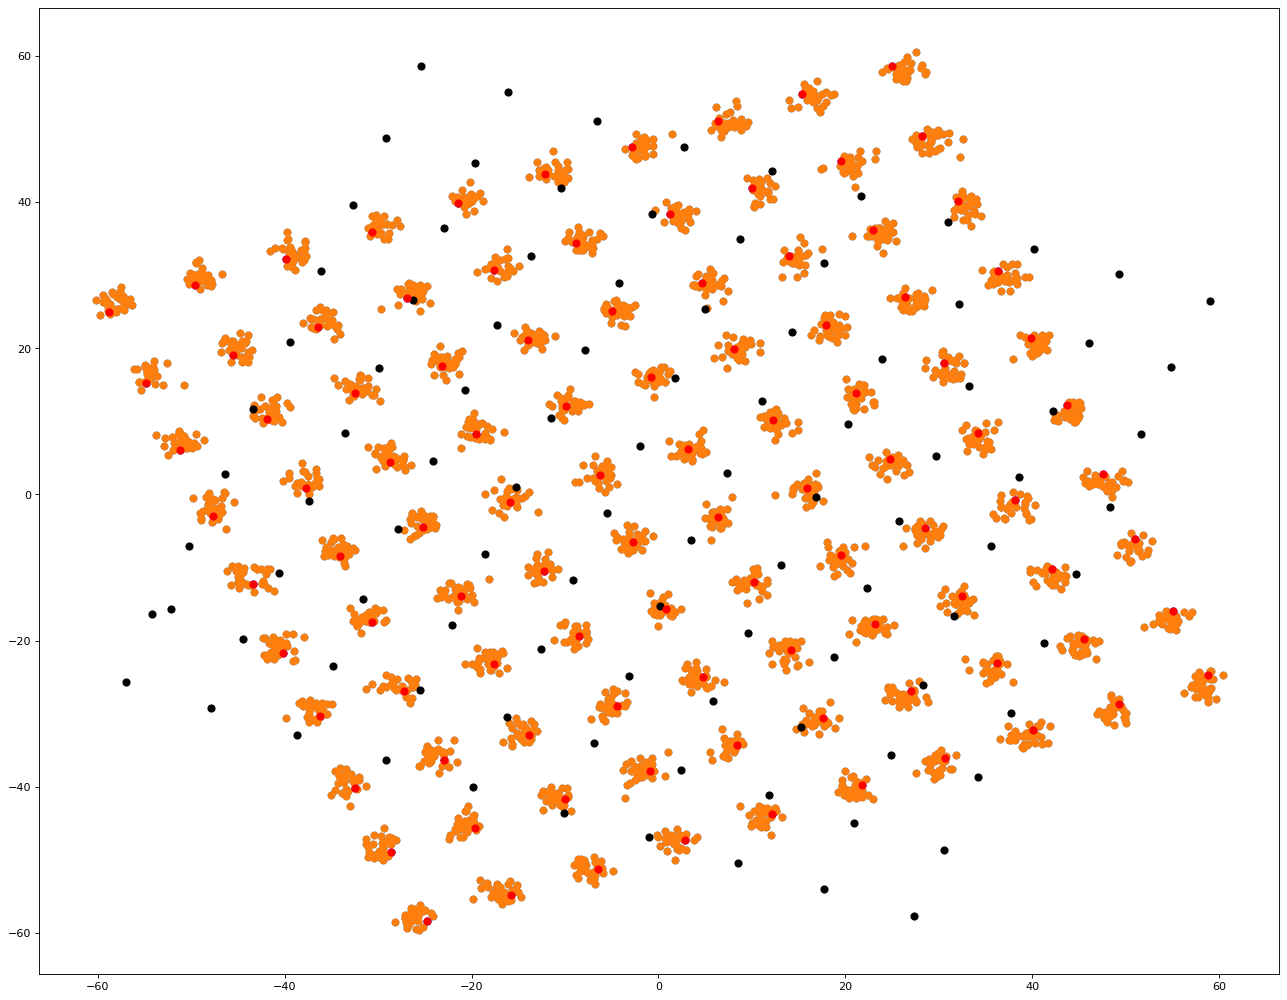

In [63]:
from matplotlib.pyplot import figure

figure(figsize=(20, 16), dpi=80)
#tcentroids
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
Xt = pca.fit_transform(points)
Tc = pca.fit_transform(tcentroids)
plot = plt.scatter(Xt[:,0], Xt[:,1])
plt.scatter(Tc[:,0] , Tc[:,1] , s = 40, color = 'blue')
# plt.legend(handles=plot.legend_elements()[0], labels=dfPoints['tlabels'])

#kcentroids
Kc = pca.fit_transform(kcentroids)
plot = plt.scatter(Xt[:,0], Xt[:,1])
plt.scatter(Kc[:,0] , Kc[:,1] , s = 40, color = 'black')
Ac = pca.fit_transform(centroids)

plt.scatter(Ac[:,0] , Ac[:,1] , s = 40, color = 'red')
plt.show()

#as the radius get smaller more errors will occur on km
#threshold is important for comparision, has to be smaller than theta 
# 4d data and get some accuracy measure of ground truth to calculated centroids

### Accuracy

### Note that spatial.distance.cosine computes the distance, and not the similarity. So, you must subtract the value from 1 to get the similarity.

In [64]:
from scipy import spatial

#similarity for tlabels
simlarityTLabels = 1 - spatial.distance.cosine(labels, tlabels)
print('similarity for tlabels')
print(simlarityTLabels)
#similarity for tlabels
print('distance for tlabels')
distanceTLabels = spatial.distance.cosine(labels, tlabels)
print(distanceTLabels)
print('similarity for klabels')
simlarityKLabels = 1 - spatial.distance.cosine(labels, klabels)
print(simlarityKLabels)
print('distance for klabels')
distanceKLabels = spatial.distance.cosine(labels, klabels)
print(distanceKLabels)

similarity for tlabels
0.8010293893710979
distance for tlabels
0.1989706106289021
similarity for klabels
0.7535456875337838
distance for klabels
0.24645431246621619


### Clustering metrics used to evaluate predictions



### Homogeneity_score

In [65]:
from sklearn.metrics.cluster import homogeneity_score
print('Homogeneity for tlabels')
homotlabels = homogeneity_score(labels, tlabels)
print(homotlabels)
print('Homogeneity for klabels')
homotlabels = homogeneity_score(labels, klabels)
print(homotlabels)


Homogeneity for tlabels
1.0
Homogeneity for klabels
0.9969897000433603


### Completeness_score

A clustering result satisfies completeness if all the data points that are members of a given class are elements of the same cluster.

In [66]:
from sklearn.metrics.cluster import completeness_score
print('completeness_score for tlabels')
homotlabels = completeness_score(labels, tlabels)
print(homotlabels)
print('completeness_score for klabels')
homotlabels = completeness_score(labels, klabels)
print(homotlabels)


completeness_score for tlabels
1.0
completeness_score for klabels
0.9985363066576981
